In [1]:
#Libraries Import
import json
import string
import numpy as np
import pandas as pd
from math import exp,log,sqrt
import matplotlib.pyplot as plt
pd.set_option("Chained_Assignment",None)


In [2]:
#read dataframe
loans=pd.read_csv("lending-club-data.csv",low_memory=False)

In [3]:
#we reassign the labels to have +1 for a safe loan, and -1 for a risky (bad) loan.
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans',axis=1)

In [4]:
#Extracting the target and the feature columns¶
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
loans = loans[features + [target]]

In [5]:
#creating dummy variables
col_cat_names=[]
[col_cat_names.append(x) for x,y in zip(loans.columns,loans.dtypes) if y==object]

for attr in col_cat_names:
    loans = loans.merge(pd.get_dummies(loans[attr], prefix=attr), left_index=True, right_index=True)
    loans.drop(attr,axis=1,inplace=True)

In [6]:
with open('module-8-assignment-2-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('module-8-assignment-2-test-idx.json') as test_data_file:    
    test_idx = json.load(test_data_file)

train_data = loans.iloc[train_idx]
test_data = loans.iloc[test_idx]

In [7]:
#revise feature list after dummy variable creation
features = list(train_data.columns)
features.remove('safe_loans')

In [8]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    
    if total_weight_positive >= total_weight_negative:
        return (total_weight_negative, +1)
    else:
        return (total_weight_positive, -1)

In [9]:
#Checkpoint: Test your intermediate_node_weighted_mistakes function, run the following cell:
example_labels = np.asarray([-1, -1, 1, 1, 1])
example_data_weights = np.asarray([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


In [10]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))
    data['data_weights'] = data_weights
    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
    
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = left_split['data_weights']
        right_data_weights = right_split['data_weights']
        
        
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(np.array(left_split[target]), np.array(left_data_weights))
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(np.array(right_split[target]), np.array(right_data_weights))
        
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes)/sum(data_weights)
                # If this is the best error we have found so far, store the feature and the error
        
        if error < best_error:
            best_feature = feature
            best_error = error
    # Return the best feature we found
    return best_feature

In [11]:
# Now, we have another checkpoint to make sure you are on the right track.



example_data_weights = np.asarray(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term_ 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


In [12]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

In [13]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print ("--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [14]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [15]:
# test code to check your implementation
example_data_weights = np.asarray([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print ('Test passed!')
else:
    print ('Test failed... try again!')
    print ('Number of nodes found:', count_nodes(small_data_decision_tree))
    print ('Number of nodes that should be there: 7' )

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade_D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

In [16]:
small_data_decision_tree

{'is_leaf': False,
 'prediction': None,
 'splitting_feature': 'term_ 36 months',
 'left': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_A',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}},
 'right': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_D',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}}

In [17]:
#Making predictions with a weighted decision tree
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:

        if annotate: 
            print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [18]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))


In [19]:
#Evaluating the tree test data
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

In [20]:
#Evaluating the tree train data
evaluate_classification_error(small_data_decision_tree, train_data)

0.40003761014399314

In [21]:
#Training a weighted decision tree
# Assign weights
example_data_weights = np.asarray([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [22]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [23]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

# QUIZ Boosting a decision stump


#### Question 1
Recall that the classification error for unweighted data is defined as follows:

classification error=# mistakes# all data points
Meanwhile, the weight of mistakes for weighted data is given by

WM(α,y^)=∑i=1nαi×1[yi≠y^i].
If we set the weights α=1 for all data points, how is the weight of mistakes WM(α,ŷ) related to the classification error?


__Ans__: WM(α,ŷ) = N * [classification error]

#### Question 2
Will you get the same model as small_data_decision_tree_subset_20 if you trained a decision tree with only 20 data points from the set of points in subset_20?

__Ans__: No

In [24]:
small_data_decision_tree_subset_20

{'is_leaf': False,
 'prediction': None,
 'splitting_feature': 'home_ownership_RENT',
 'left': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_F',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}},
 'right': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_D',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}}

#### Question 3
Refer to the 10-component ensemble of tree stumps trained with Adaboost.

As each component is trained sequentially, are the component weights monotonically decreasing, monotonically increasing, or neither?

__Ans__: Neither

In [25]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.asarray([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x) ,axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error

        weighted_error = np.sum(np.array(is_wrong) * alpha) * 1. / np.sum(alpha)
        
        # Compute model coefficient using weighted error
    
        weight = 1. / (2 * log((1 - weighted_error) * 1. / (weighted_error)))
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights

        alpha = alpha * np.array(adjustment)
        alpha = alpha / np.sum(alpha)
    
    return weights, tree_stumps

In [26]:
# Checking your Adaboost code
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.


In [27]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print ("(leaf, label: %s)" % tree['prediction'])
        return None
    print(split_name)
    split_feature, split_value = split_name.split('_')
    print ('                       root')
    print ('         |---------------|----------------|')
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name))))
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

In [28]:
print_stump(tree_stumps[0])

term_ 36 months
                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [29]:
print_stump(tree_stumps[1])

term_ 36 months
                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: 1)                 (leaf, label: -1)


In [30]:
print (stump_weights)

[1.5819847465691852, 0.1755672953299271]


In [31]:
# Training a boosted ensemble of 10 stumps¶
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
-------------------------

In [32]:
# Making predictions
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.asarray([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x),axis=1)
        
        # Accumulate predictions on scores array
        scores = scores + stump_weights[i] * np.array(predictions)
        
        
    return np.asarray([1 if x>=0 else -1 for x in list(scores) ])

In [33]:
traindata_predictions = predict_adaboost(stump_weights, tree_stumps, train_data)
train_accuracy = np.sum(np.array(train_data[target]) == traindata_predictions) / float(len(traindata_predictions))
print ('training data Accuracy of 10-component ensemble = %s' % train_accuracy)

training data Accuracy of 10-component ensemble = 0.5665699548678272


In [34]:
stump_weights

[1.5819847465691852,
 0.1755672953299271,
 0.20025823465226367,
 0.23852005822154976,
 0.30879072026642856,
 0.49918223815354196,
 1.4102406583552591,
 0.2027631012808904,
 0.242670654683562,
 0.31744733938956077]

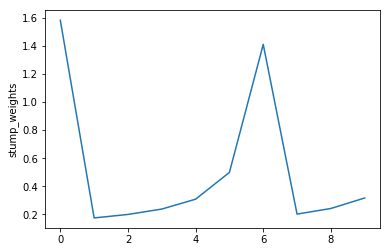

In [35]:
plt.plot(stump_weights)
plt.ylabel("stump_weights")
plt.show()

#### Question 4
Which of the following best describes a general trend in accuracy as we add more and more components? Answer based on the 30 components learned so far.


In [36]:

stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
-------------------------

Split on feature home_ownership_MORTGAGE. (19846, 17378)
--------------------------------------------------------------------
Subtree, depth = 2 (19846 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (17378 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_MORTGAGE. (19846, 17378)
--------------------------------------------------------------------
Subtree, depth = 2 (19846 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (17378 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ow

Split on feature home_ownership_MORTGAGE. (19846, 17378)
--------------------------------------------------------------------
Subtree, depth = 2 (19846 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (17378 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_MORTGAGE. (19846, 17378)
--------------------------------------------------------------------
Subtree, depth = 2 (19846 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (17378 data points).
Reached maximum depth. Stopping for now.


In [37]:
#Computing training error at the end of each iteration

error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = np.sum(np.array(train_data[target]) != predictions) / float(len(predictions))
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.4216365785514722
Iteration 3, training error = 0.4216365785514722
Iteration 4, training error = 0.4216365785514722
Iteration 5, training error = 0.4216365785514722
Iteration 6, training error = 0.4216365785514722
Iteration 7, training error = 0.4334300451321728
Iteration 8, training error = 0.4334300451321728
Iteration 9, training error = 0.4334300451321728
Iteration 10, training error = 0.4334300451321728
Iteration 11, training error = 0.4216365785514722
Iteration 12, training error = 0.4673329035031163
Iteration 13, training error = 0.4673329035031163
Iteration 14, training error = 0.4673329035031163
Iteration 15, training error = 0.4673329035031163
Iteration 16, training error = 0.4673329035031163
Iteration 17, training error = 0.4673329035031163
Iteration 18, training error = 0.4673329035031163
Iteration 19, training error = 0.4673329035031163
Iteration 20, training error = 0.4673329035031163
Iteration

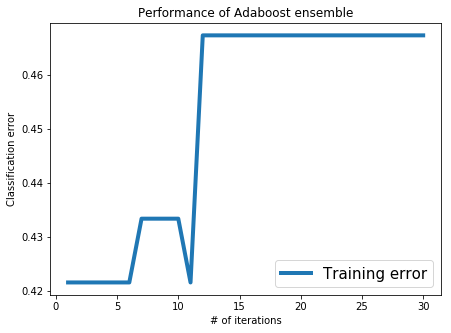

In [38]:
# Visualizing training error vs number of iterations
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size': 16})

In [39]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = np.sum(np.array(test_data[target]) != predictions) / float(len(predictions))
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

    

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.4233089185695821
Iteration 3, test error = 0.4233089185695821
Iteration 4, test error = 0.4233089185695821
Iteration 5, test error = 0.4233089185695821
Iteration 6, test error = 0.4233089185695821
Iteration 7, test error = 0.42847910383455406
Iteration 8, test error = 0.42847910383455406
Iteration 9, test error = 0.42847910383455406
Iteration 10, test error = 0.42847910383455406
Iteration 11, test error = 0.4233089185695821
Iteration 12, test error = 0.4658552348125808
Iteration 13, test error = 0.4658552348125808
Iteration 14, test error = 0.4658552348125808
Iteration 15, test error = 0.4658552348125808
Iteration 16, test error = 0.4658552348125808
Iteration 17, test error = 0.4658552348125808
Iteration 18, test error = 0.4658552348125808
Iteration 19, test error = 0.4658552348125808
Iteration 20, test error = 0.4658552348125808
Iteration 21, test error = 0.4658552348125808
Iteration 22, test error = 0.4658552348

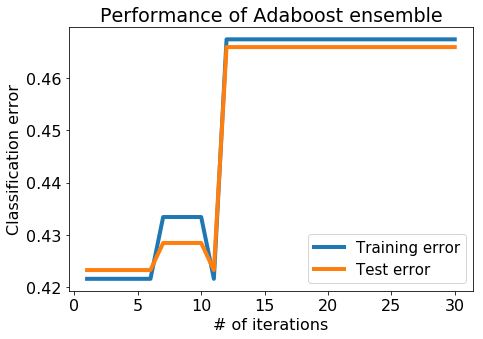

In [40]:
# Visualize both the training and test errors
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

#### Question 5
From this plot (with 30 trees), is there massive overfitting as the # of iterations increases?

__Ans__: No